In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from numpy import expand_dims, zeros, ones, asarray
from numpy.random import randn, randint

#from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Model, Sequential

from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, Dropout, Lambda, Activation

#from keras.utils import to_categorical
import cv2,os      
from matplotlib import pyplot as plt
from keras import backend as K
import numpy as np
from tqdm import tqdm

In [3]:
class_names = ['glioma_tumor','meningioma_tumor','no_tumor','pituitary_tumor' ]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
IMAGE_SIZE = (128, 128)

In [4]:
def load_data():
    """
        Load the data:
            - 14,034 images to train the network.
            - 3,000 images to evaluate how accurately the network learned to classify images.
    """
    TrainF=r"/kaggle/input/brain-tumor-classification-mri/Training"
    TestF=r"/kaggle/input/brain-tumor-classification-mri/Testing"
    datasets =  [TrainF,TestF]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                image = cv2.resize(image, (IMAGE_SIZE)) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [5]:
(trainx, trainy), (testX, testy) = load_data()

Loading /kaggle/input/brain-tumor-classification-mri/Training


100%|██████████| 826/826 [00:07<00:00, 114.81it/s]


Loading /kaggle/input/brain-tumor-classification-mri/Testing


100%|██████████| 100/100 [00:01<00:00, 90.75it/s]


In [6]:
print(trainx.shape, trainy.shape, '\n')

(2870, 128, 128) (2870,) 



In [7]:
print(trainx.shape, trainy.shape, '\n')
np.random.seed(42)
trainsize = 2870  # number of training images we use, selected randomly
randtrain = np.random.choice(trainx.shape[0], trainsize, replace=True)
train_images, train_labels = trainx[randtrain], trainy[randtrain]
print(train_images.shape, train_labels.shape)

(2870, 128, 128) (2870,) 

(2870, 128, 128) (2870,)


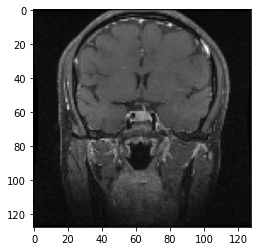

In [8]:
plt.figure()
plt.imshow(train_images[22])
plt.imshow(train_images[22], cmap='gray')
plt.show()

In [9]:
import tensorflow as tf
train_images = train_images.reshape(train_images.shape[0], 128, 128, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = trainsize
BATCH_SIZE = 8
g_loss = []
d_loss = []

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [10]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(32*32*1024, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((32, 32, 1024)))
    assert model.output_shape == (None, 32, 32, 1024) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 32, 32, 512)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 64, 256)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 128, 128, 1)

    return model

In [11]:
from tensorflow import keras
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

In [12]:
import glob
import os
import PIL
import time

from IPython import display

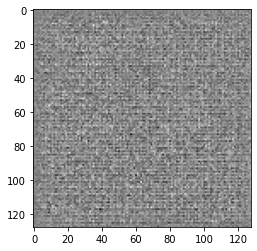

In [13]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [14]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[128, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-5.5430246e-05]], shape=(1, 1), dtype=float32)


In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def discriminator_loss(real_output, fake_output, d_loss):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    d_loss.append(total_loss)
    return total_loss

In [18]:
def generator_loss(fake_output, g_loss):
    fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    g_loss.append(fake_loss)
    return fake_loss

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [20]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [21]:
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 9

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output, g_loss)
      disc_loss = discriminator_loss(real_output, fake_output, d_loss)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(8,8))

  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

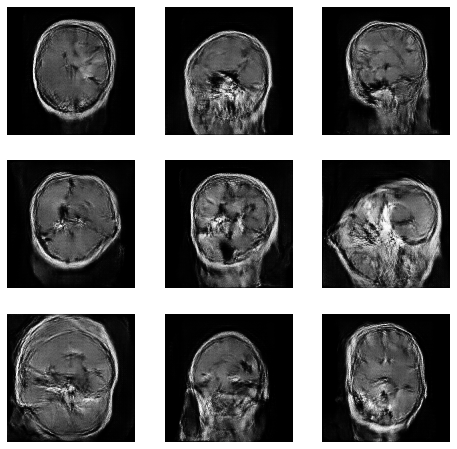

Time for epoch 209 is 53.52785110473633 sec


In [ ]:
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


In [ ]:
noi = tf.random.normal([1, 100])
sample = checkpoint.generator(noi, training=False)
plt.imshow(sample[0, :, :, 0], cmap='gray')

In [ ]:
val = checkpoint.discriminator(sample)
print (val)

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(g_loss, label='generator')
plt.plot(d_loss, label = 'discriminator')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.ylim([0,7])
plt.legend(loc='upper right')
plt.show()

In [ ]:
disc = checkpoint.discriminator
disc.summary()

In [ ]:
val = disc(sample)
print (val)

In [ ]:
new_model = Sequential()

for i in range(len(disc.layers) - 1):
    new_model.add(disc.layers[i])

# Freeze the layers 
for layer in new_model.layers:
    layer.trainable = False    
    
new_model.add(Dense(2, activation='softmax'))
new_model.summary()

In [ ]:
new_model.layers[-1].weights

In [ ]:
(train_img, train_lb), (test_img, test_lb) = load_data()

np.random.seed(42)
trainsize = 205  # number of training images we use, selected randomly
randtrain = np.random.choice(train_img.shape[0], trainsize, replace=False)
X_train, y_train = train_img[randtrain], train_lb[randtrain]

np.random.seed(10)
testsize = 30  # number of testing images we use, selected randomly
randtest = np.random.choice(test_img.shape[0], testsize, replace=False)
X_test, y_test = test_img[randtest], test_lb[randtest]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [ ]:
train_images = X_train.reshape((trainsize, 128, 128, 1))

train_images = (train_images.astype('float32') - 127.5) / 127.5

test_images = X_test.reshape((testsize, 128, 128, 1))
test_images = (test_images.astype('float32') - 127.5) / 127.5

train_labels = to_categorical(y_train)
test_labels = to_categorical(y_test)

new_model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['accuracy'])

history = new_model.fit(train_images, train_labels, batch_size=5, epochs=50,validation_data=(test_images, test_labels))

In [ ]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
# demonstration: predict the ith test digit
i = 25
prediction = new_model.predict(test_images[i].reshape(1,128,128,1))

# get probability distribution and classification of the test digit
print(prediction)
print('prediction:', np.argmax(prediction))

# draw the barplot
plt.figure()
plt.bar(np.arange(0,2).astype('str'), prediction[0,:])
plt.show()

In [ ]:
print('actual label:', np.argmax(test_labels[i]))
plt.figure()
plt.imshow(test_images[i,:,:,0], cmap='gray')
plt.show()

In [ ]:
pred_labels = new_model.predict(test_images).argmax(axis=1)
true_labels = test_labels.argmax(axis=1)

In [ ]:
train_labels= train_labels.argmax(axis=1)

In [ ]:
pred_labels1 = new_model.predict(train_images).argmax(axis=1)


In [ ]:
confusion_mat = tf.math.confusion_matrix(labels=true_labels, predictions=pred_labels).numpy()
confusion_mat

In [ ]:
import pandas as pd
import seaborn as sns

confusion_mat_norm = np.around(confusion_mat.astype('int') / np.atleast_2d(confusion_mat.sum(axis=1)).T, decimals=2)

classes = np.arange(0,4).astype('str')
confusion_mat_df = pd.DataFrame(confusion_mat_norm,
                                index = class_names_label, 
                                columns = class_names_label)
ax = plt.axes()
figure = plt.figure()
sns.heatmap(confusion_mat_df, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
new_model.evaluate(test_images, verbose=1)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

CM = confusion_matrix(true_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,fmt=".0f",  
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Test Confusion matrix')
plt.show()
plt.savefig('output8.png', dpi=300, bbox_inches='tight')

In [ ]:
from sklearn.metrics import classification_report,accuracy_score
results = dict()

test_cm = confusion_matrix(true_labels, pred_labels)
results['Test'] = {'classification_acc': accuracy_score(pred_labels, true_labels),
                      'True Positive': test_cm[1,1], 'False Positive': test_cm[1,0],
                      'False Negative': test_cm[0,1], 'True Negative': test_cm[0,0]}

pd.DataFrame(data=results)
print("Train Confusin Matrix Values")
print(test_cm)

In [ ]:
print('Testing Set')
test_precision1 = float(test_cm[1,1]) / ((test_cm[1,1]) + test_cm[1,0])
print("Precision: %f" % test_precision1)
test_npv1 = float(test_cm[0,0]) / ((test_cm[0,0]) + test_cm[0,1])
print("Negative predictive value: %f" % test_npv1)
test_recall1 = float(test_cm[1,1]) / ((test_cm[1,1]) + test_cm[0,1])
print("Sensitivity (Recall): %f" % test_recall1)
test_specificity1 = float(test_cm[0,0]) / ((test_cm[0,0]) + test_cm[1,0])
print("Specificity: %f" % test_specificity1)
test_f1_1 = 2 * (test_precision1 * test_recall1) / (test_precision1 + test_recall1)
print("F1 score: %f" % test_f1_1)
print(" ")

In [ ]:
from sklearn.metrics import accuracy_score
print("Accuracy : {}".format(accuracy_score(true_labels, pred_labels)))